In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
#source('tests.R')
#source("cleanup.R")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
heart_attack_data_raw = read_delim("https://raw.githubusercontent.com/RichardAdhika22/group115/main/reprocessed.hungarian.data",delim=" ",col_names=FALSE)
colnames(heart_attack_data_raw) = c('age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num')
heart_attack_data_raw

Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: " "
dbl (14): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
40,1,2,140,289,0,0,172,0,0,-9,-9,-9,0
49,0,3,160,180,0,0,156,0,1,2,-9,-9,1
37,1,2,130,283,0,1,98,0,0,-9,-9,-9,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
48,1,3,110,211,0,0,138,0,0,-9,-9,6,0
47,0,2,140,257,0,0,135,0,1,1,-9,-9,0
53,1,4,130,182,0,0,148,0,0,-9,-9,-9,0


In [8]:
heart_attack_data = select(heart_attack_data_raw,sex,trestbps,chol,thalach,cp,num)
#heart_attack_data = mutate(heart_attack_data,cp=as.factor(cp),num=as.factor(num))
heart_attack_data

sex,trestbps,chol,thalach,cp,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,140,289,172,2,0
0,160,180,156,3,1
1,130,283,98,2,0
⋮,⋮,⋮,⋮,⋮,⋮
1,110,211,138,3,0
0,140,257,135,2,0
1,130,182,148,4,0


In [9]:
table_means = select(heart_attack_data,-sex) |>
group_by(num) |>
summarize(across(trestbps:cp,mean))
colnames(table_means) = c('num',"mean terstbps","mean chol","mean thalach","mean cp")
table_means

num,mean terstbps,mean chol,mean thalach,mean cp
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,129.9894,216.1170,144.1862,2.617021
1,128.0000,245.3243,138.8649,3.621622
2,137.6923,247.6923,124.2692,3.807692
3,141.2857,253.8571,123.2143,3.392857
4,141.8667,301.2000,122.0000,3.800000


In [10]:
table_num_count = heart_attack_data |>
group_by(num) |>
summarize("total amount of num"=n())
table_num_count
num_count_col = pull(table_num_count, 'total amount of num')
num_count_col

num,total amount of num
<dbl>,<int>
0,188
1,37
2,26
3,28
4,15


[1] 188  37  26  28  15

In [11]:
summary_table = bind_cols(table_means,num_count_col)
colnames(summary_table) = c('num',"mean terstbps","mean chol","mean thalach","mean cp","total count of num")
summary_table

New names:
• `` -> `...6`


num,mean terstbps,mean chol,mean thalach,mean cp,total count of num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,129.9894,216.1170,144.1862,2.617021,188
1,128.0000,245.3243,138.8649,3.621622,37
2,137.6923,247.6923,124.2692,3.807692,26
3,141.2857,253.8571,123.2143,3.392857,28
4,141.8667,301.2000,122.0000,3.800000,15


In [12]:
#Visualizations

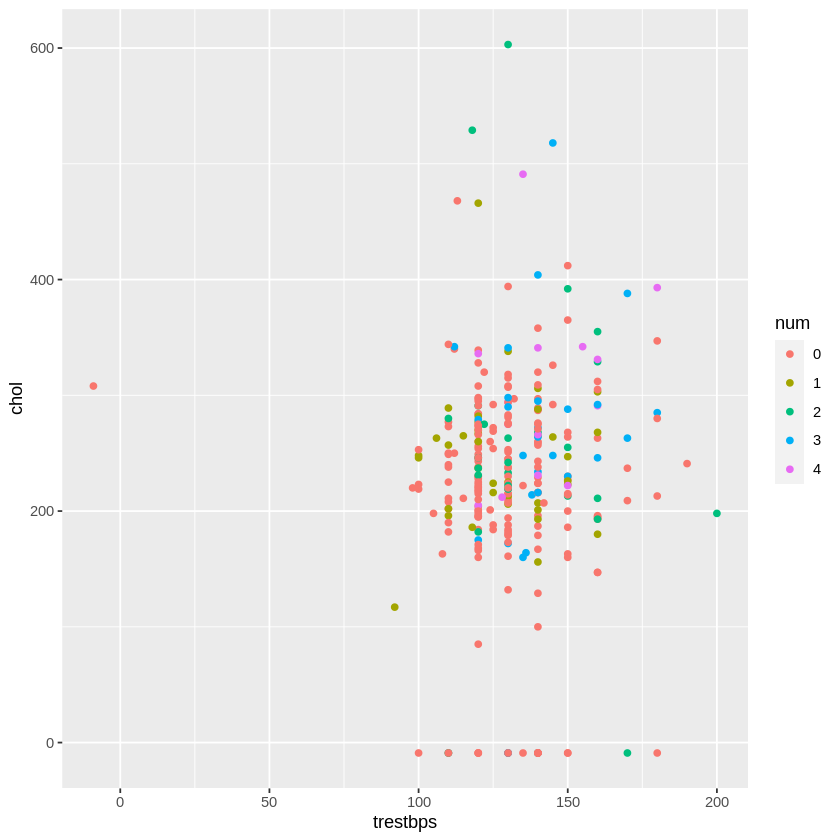

In [20]:
heart_attack_data_factored = mutate(heart_attack_data_raw,num=as.factor(num))
ggplot(heart_attack_data_factored,aes(x=trestbps,y=chol,color=num))+
geom_point()